# Definición del problema

La oferta de casas y departamentos en Santiago de Chile es inmensa, y cada una de ellas posee gran variedad de características que se ajustan a las múltiples necesidades de las personas, tales como el número de habitaciones, baños o estacionamientos, la ubicación de la comuna o la cercanía a metros o supermercados. Este variedad de opciones implica una amplia variedad en los precios de los inmuebles afectadas según las características que estos poseen, y esto a su vez, repercute en las decisiones que toman las personas al momento de escoger sus viviendas, en la que se balancea las características y comodidades deseadas según el presupuesto disponible para arrendar o comprar una propiedad.

El presente trabajo nace desde la necesidad del investigador y su pareja en arrendar una vivienda en Santiago y, aprovechando este proceso de mudanza, el planteamiento de la tarea y la misma curiosidad, se desea descubrir cuales son las características que más influyen en el precio de arriendo de un departamento en Santiago, y así ampliar el conocimiento del mercado inmobiliario y, en el mejor de los casos, ayudar al investigador a tomar una decisión más acertada del departamento adecuado para arrendar.

# Descripción del conjunto de datos

El conjunto de datos fue obtenido desde el sitio web Portal Inmobiliario a través del método *web-scraping* programado por el investigador, todo el proceso documentado en [github](https://github.com/smenaaliaga/rent-apartment-system/). Del sitio web se extrajo la totalidad de la oferta de arriendos de departamentos de las comunas de Santiago al día viernes 13 de mayo del 2022.

Las variables obtenidas son :

- titulo : Titulo descriptivo del departamento
- comuna : Comuna donde esta ubicado el departamento
- estacion_cercana : Estación de metro cercana, si es que posee (menos de 2 km)
- distancia_estacion : Distancia (en metros) de la estación más cercana, si es que posee
- dormitorios : Cantidad de dormitorios
- baños : Cantidad de baños
- estacionamientos : Cantidad de estacionamientos
- bodegas : Cantidad de bodegas
- superficie_total : Superficie total del departamento en metros cuadrados (m2)
- superficie_util : Superficie util del departamento en metros cuadrados (m2)
- currency_symbol : Tipo de unidad monetaria cual se paga el precio del departamento (UF o CLP)
- precio : Precio mensual del arriendo del departamento en CLP
- gastos_comunes : Valor del gasto común en CLP
- search_gc : Indicador de donde a obtenido el gasto común, 0 si lo obtuvo directamente o 1 si fue desde la descripción
- descripcion : Descripción del departamento
- ubicacion : Ubicación del departamento
- lat : Latitud del departamento
- long : Longitud del departamento
- url : URL original de donde se obtuvo la data del departamento

La extracción de los datos consideró un preprocesamiento de estos, eliminando texto y cáracteres especial de algunas variables numericas tales como el precio, los m2 de la superficie, entre otros. También se optó por tratar la extracción de la descripciones de los departamentos, aplicando *lowercase* al texto, normalización a ASCII y eliminación de cáracteres especiales. Por otro lado, no todos los departamentos tenían el valor de su gasto común en la sección habilitada por el sitio, y muchas veces los oferentes del departamento optaban por ingresar el valor del gasto común en la descripción, por lo que, se automatizó su obtención desde la descripción cuando esta no se encontraba en la sección de gastos comunes. Además, se obtuvieron las latitudes y longitudes de todas las estaciones de metro (tambén a través de *web-scraping*), y teniendo la latitud y longitud del propio departamiento, se obtuvo la estación del metro y la distancia más cercana al departamento de la estación, haciendo uso de la formula de Haversine.

Además, la exploración de los datos se observaron algunos datos atípicos, con precios desorbitantes a la billetera "común" o cantidades de baños o dormitorios que rozan la innecesidad propia de una familia convencional, por lo que simplemente se eliminan del dataset. 

Las columnas "titulo", "currency_symbol", "search_gc", "ubicación" y "url" son únicas por departamento o no entregan información adicional para la clasificación, por lo que no fueron consideradas dentro de la investigación. Además, se excluye de la investigación la variable "descripcion" aún sabiendo que en ella se podría obtener información relevante, esta variable será considerada para futuros trabajos.

# Carga y preprocesamiento de datos

In [94]:
import warnings; warnings.simplefilter('ignore')

In [95]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [96]:
# Carga
df = pd.read_csv('data/departamentos.csv')
df.shape

(5968, 19)

Luego de realizar el *scraping* de toda la oferta de arriendo de departamentos de las comunas en Santiago al día 13 de mayo 2022, se obtuvo un total de 5968 registros.

## ETL

In [97]:
# Conversión del tipo de dato
df['precio'] = df['precio'].astype(float)
df['gastos_comunes'] = df['gastos_comunes'].astype(float)
df['superficie_total'] = df['superficie_total'].replace(to_replace=",", value='.', regex=True)
df['superficie_total'] = df['superficie_total'].astype(float)
df['superficie_util'] = df['superficie_util'].replace(to_replace=",", value='.', regex=True)
df['superficie_util'] = df['superficie_util'].astype(float)
# Filtro de columnas no consideradas
df = df[df.columns[~df.columns.isin(['titulo','currency_symbol','search_gc','descripcion','direccion','ubicacion','url'])]]
# Se filtran columna de estación de metro cercanas, dado que se obtiene de otra manera
df = df[df.columns[~df.columns.isin(['estacion_cercana','distancia_estacion'])]]
# Si no hay valor de gasto comun, se asume que es 0
df['gastos_comunes'] = df['gastos_comunes'].fillna(0)
# Si no hay valor en estacionamientos y bodegas, se asume que es 0
df['estacionamientos'] = df['estacionamientos'].fillna(0)
df['bodegas'] = df['bodegas'].fillna(0)
# Agregar precio total
df['precio_total'] = df['precio'] + df['gastos_comunes']

Si bien el metro cercano y su distancia a los departamentos son datos que aportaba Portal Inmobiliario, estos datos solo estaban presentes si el departamento tenía un metro cercano a menos de 2km, y dado que se considera un dato relevante para la investigación, se optó por cálcular estos valores para todos los departamentos. Para ello, se obtuvieron las latitudes y longitudes de todas las estaciones de metros a través del método *web-scraping*, y con las latitudes y longitudes de cada departamento que fueron obtenidos en el primer *scraping*, se calculó las distancias (usando Haversine) entre estaciones de metro y se almacenó aquella estación (y su distancia) que sea más cercana al departamento.

In [98]:
# Obtención del estaciones de metros más cercanas a los departamentos y sus distancias en metros
import sys
sys.path.append('../utils/')
from estaciones_cercanas import estaciones_cercanas
# La función añade al data frame la columna con el metro mas cercano y su distancia (metros)
df = estaciones_cercanas(df)

# Análisis Exploratorio de Datos (AED)

In [99]:
df.head()

,comuna,dormitorios,baños,estacionamientos,bodegas,superficie_total,superficie_util,precio,gastos_comunes,lat,long,precio_total,distancia_estacion,estacion_cercana
0,Cerrillos,3.0,1.0,1.0,0.0,80.0,80.0,450000.0,4000.0,-33.505603,-70.734114,454000.0,1980.421945,Lo Errázuriz
1,Cerrillos,3.0,2.0,1.0,0.0,66.0,66.0,450000.0,55000.0,-33.507878,-70.724669,505000.0,1940.623326,Lo Errázuriz
2,Cerrillos,3.0,2.0,0.0,0.0,90.0,80.0,580000.0,120000.0,-33.503846,-70.704701,700000.0,2241.346045,Lo Errázuriz
3,Cerrillos,3.0,1.0,0.0,0.0,66.0,66.0,380000.0,5000.0,-33.506189,-70.730548,385000.0,1887.067564,Lo Errázuriz
4,Cerrillos,3.0,2.0,1.0,0.0,90.0,90.0,600000.0,80000.0,-33.500000,-70.733300,680000.0,1436.677200,Lo Errázuriz


### Análisis de valores perdidos NaN

In [100]:
# Revisión de NaN
pd.isna(df).sum()

comuna                  0
dormitorios            35
baños                  29
estacionamientos        0
bodegas                 0
superficie_total       89
superficie_util       155
precio                  0
gastos_comunes          0
lat                     0
long                    0
precio_total            0
distancia_estacion      0
estacion_cercana        0
dtype: int64

Se observar valores perdidos en las variables dormitorios, baños, superficie_total y útil, no es posible asumir facilmente un valor para estas variables, además representan una cantidad marginal del subconjunto, por lo que se eliminan del dataset aquellos registros que no posean datos en dormitorios, baños y sperficie_total. No se eliminan las de superficie_util, dado que la información de esta esta contenida en superficie_total, y hay menos perdidas si se trabaja con superficie_total.

In [101]:
df = df[df['dormitorios'].notna()]
df = df[df['baños'].notna()]
df = df[df['superficie_total'].notna()]
pd.isna(df).sum()

comuna                 0
dormitorios            0
baños                  0
estacionamientos       0
bodegas                0
superficie_total       0
superficie_util       67
precio                 0
gastos_comunes         0
lat                    0
long                   0
precio_total           0
distancia_estacion     0
estacion_cercana       0
dtype: int64

Se eliminan las columnas que contienen información altamente redundante (colineales) que estan ya presentes en otras variables, tales como:
- superficie_util: información presente en superficie_total
- precio y gastos_comunes : información presente en precio_total

In [102]:
# Se eliminan variables que contienen información altamente redundante en otras variable
df = df[df.columns[~df.columns.isin(['superficie_util','precio','gastos_comunes'])]]

In [103]:
df.head()

,comuna,dormitorios,baños,estacionamientos,bodegas,superficie_total,lat,long,precio_total,distancia_estacion,estacion_cercana
0,Cerrillos,3.0,1.0,1.0,0.0,80.0,-33.505603,-70.734114,454000.0,1980.421945,Lo Errázuriz
1,Cerrillos,3.0,2.0,1.0,0.0,66.0,-33.507878,-70.724669,505000.0,1940.623326,Lo Errázuriz
2,Cerrillos,3.0,2.0,0.0,0.0,90.0,-33.503846,-70.704701,700000.0,2241.346045,Lo Errázuriz
3,Cerrillos,3.0,1.0,0.0,0.0,66.0,-33.506189,-70.730548,385000.0,1887.067564,Lo Errázuriz
4,Cerrillos,3.0,2.0,1.0,0.0,90.0,-33.500000,-70.733300,680000.0,1436.677200,Lo Errázuriz


Luego de observar la cabecera de los datos, es importante señalar las distinciones entre las variables

#### Variable Y de respuesta (cuantitativa continua) :

- precio_total

#### Variables X predictoras :

Variables categoricas

- comuna
- estacion_cercana

Variables cuatitativas discretas

- dormitorios
- baños
- estacionamientos
- bodegas

Variables cuantitativas continuas

- lat
- long
- distancia_estacion
- superficie_total

### Resumen de la variable Y de respuesta: precio_total

In [104]:
df[['precio_total']].describe()

,precio_total
count,5.824000e+03
mean,2.793388e+06
std,2.701794e+07
min,1.850000e+05
25%,4.470000e+05
50%,6.659545e+05
75%,1.497398e+06
max,1.051847e+09


Se observa un precio total máximo muy desorbitante respecto al 75% del conjunto.

Se opta por trabajar con precios totales menores a $2.000.000$ CLP, que representa solo $500.000$ CLP más del tercer cuartil ($75\%$) de los precios.

In [105]:
df = df.loc[(df['precio_total'] <= 2000000)]
df[['precio_total']].describe()

,precio_total
count,5.017000e+03
mean,7.821341e+05
std,4.666356e+05
min,1.850000e+05
25%,4.250000e+05
50%,5.800000e+05
75%,1.030000e+06
max,2.000000e+06


Text(0.5, 1.0, 'Histograma de precio total en CLP')

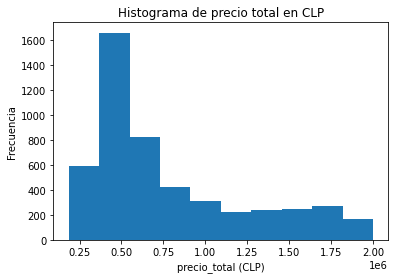

In [119]:
plt.hist(df["precio_total"])
plt.xlabel("precio_total (CLP)")
plt.ylabel("Frecuencia")
plt.title("Histograma de precio total en CLP")

### Resumen de variables predictora cuantitativas

In [107]:
# Resumén estadístico de variables númericas
df[df.columns[~df.columns.isin(['precio_total','lat','long'])]].describe()

,dormitorios,baños,estacionamientos,bodegas,superficie_total,distancia_estacion
count,5017.000000,5017.000000,5017.000000,5017.000000,5017.000000,5.017000e+03
mean,2.008372,1.714969,0.826590,0.430735,134.675260,4.131880e+03
std,0.960924,0.825047,2.990053,2.815080,2420.225614,2.188286e+05
min,1.000000,1.000000,0.000000,0.000000,1.000000,5.628300e+00
25%,1.000000,1.000000,0.000000,0.000000,40.000000,3.224206e+02
50%,2.000000,2.000000,1.000000,0.000000,57.000000,5.217782e+02
75%,3.000000,2.000000,1.000000,1.000000,94.000000,8.794682e+02
max,22.000000,20.000000,140.000000,180.000000,160020.000000,1.549002e+07


Nuevamente se observan casos atípicos en todas las columnas, por lo que se decide filtrar considerando valores razonables un poco mayores al 75% de los datos.

In [108]:
# Tratamiento de los casos atípicos
df = df.loc[(df['dormitorios'] <= 5)]
df = df.loc[(df['baños'] <= 5)]
df = df.loc[(df['estacionamientos'] <= 3)]
df = df.loc[(df['bodegas'] <= 3)]
df = df.loc[(df['superficie_total'] <= 300)]
df = df.loc[(df['distancia_estacion'] <= 8000)]
df.shape

(4958, 11)

Luego de aplicar todos los filtros, se obtuvo un dataset total de 4968 departamentos, reduciendo aproximandamente un $20\%$ del conjunto original.

In [109]:
df[df.columns[~df.columns.isin(['precio_total','lat','long'])]].describe()

,dormitorios,baños,estacionamientos,bodegas,superficie_total,distancia_estacion
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,1.997378,1.704720,0.723477,0.376160,73.101666,793.637068
std,0.902439,0.768519,0.701865,0.493546,44.698207,840.650187
min,1.000000,1.000000,0.000000,0.000000,1.000000,5.628300
25%,1.000000,1.000000,0.000000,0.000000,40.000000,322.344898
50%,2.000000,2.000000,1.000000,0.000000,56.000000,518.046990
75%,3.000000,2.000000,1.000000,1.000000,92.000000,874.582846
max,5.000000,5.000000,3.000000,3.000000,300.000000,5737.590614


Text(0.5, 0.98, 'Diagramas de barras de dormitorios, baños, estacionamientos y bodegas')

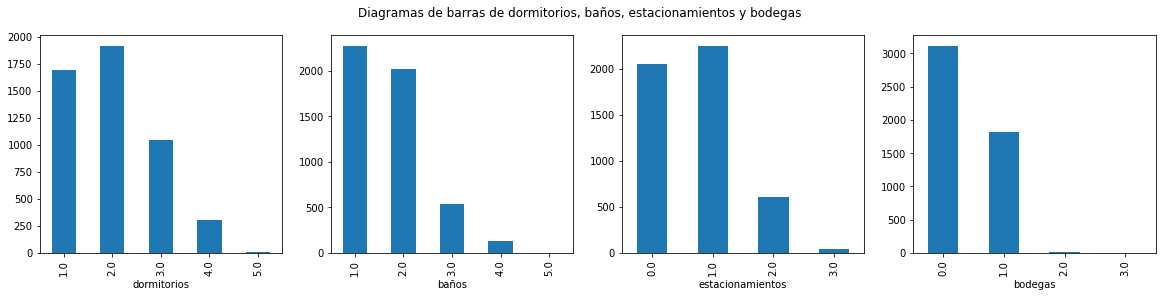

In [110]:
figure, axs = plt.subplots(1,4, figsize=(20,4))
df.groupby(['dormitorios'])['dormitorios'].count().plot(kind='bar', ax=axs[0])
df.groupby(['baños'])['baños'].count().plot(kind='bar', ax=axs[1])
df.groupby(['estacionamientos'])['estacionamientos'].count().plot(kind='bar', ax=axs[2])
df.groupby(['bodegas'])['bodegas'].count().plot(kind='bar', ax=axs[3])
plt.suptitle("Diagramas de barras de dormitorios, baños, estacionamientos y bodegas")

Text(0.5, 1.0, 'Histograma de distancias a estaciones más cercanas (m)')

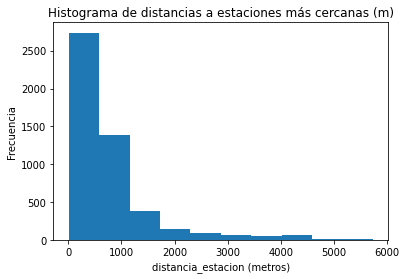

In [111]:
plt.hist(df["distancia_estacion"])
plt.xlabel("distancia_estacion (metros)")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancias a estaciones más cercanas (m)")

Text(0.5, 1.0, 'Histograma de superficie total (m2)')

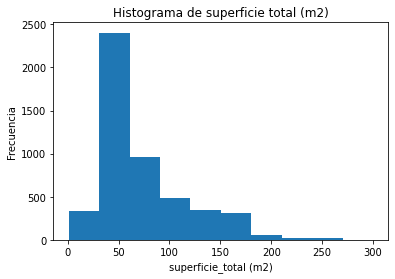

In [112]:
plt.hist(df["superficie_total"])
plt.xlabel("superficie_total (m2)")
plt.ylabel("Frecuencia")
plt.title("Histograma de superficie total (m2)")

### Resumen de variables predictoras categoricas

In [113]:
# Resumén estadístico de variables categoricas
df.describe(include = ['O'])

,comuna,estacion_cercana
count,4958,4958
unique,31,113
top,Santiago,Manquehue
freq,1319,339


In [114]:
# Resumen por comuna
df.groupby(['comuna'])['comuna'].count().sort_values(ascending=False).head(10)

comuna
Santiago         1319
Las Condes        951
Providencia       458
San Miguel        447
Ñuñoa             408
Vitacura          376
La Florida        187
La Cisterna       159
Macul             141
Independencia     139
Name: comuna, dtype: int64

Las comunas con la oferta más grande en arriendo de departamentos es Santiago representando un $22.1\%$ de la muestra, seguido de Las Condes con un $16\%$ y Providencia con un $7.7\%$

In [115]:
# Resumen por estción cercana, 10 primeras (de 45)
df.groupby(['estacion_cercana'])['estacion_cercana'].count().sort_values(ascending=False).head(10)

estacion_cercana
Manquehue                 339
Escuela Militar           270
Los Dominicos             214
San Miguel                197
Santa Ana                 168
Parque Almagro            163
Santa Lucía               157
Alcántara                 147
Hernando de Magallanes    132
Inés de Suárez            125
Name: estacion_cercana, dtype: int64

Si bien es la comuna de Santiago la que posee la mayor oferta de arriendo de departamentos, son las estaciones de metro de la comuna de Las Condes (linea 1) la que poseen mayor cantidad de departamentos cercanos: Manquehue, Escuela Militar y Los Dominicos 

### Mapa de los departamentos

Text(0.5, 1.0, 'Scatterplot de lat y long de departamentos (mapa de calor de precios)')

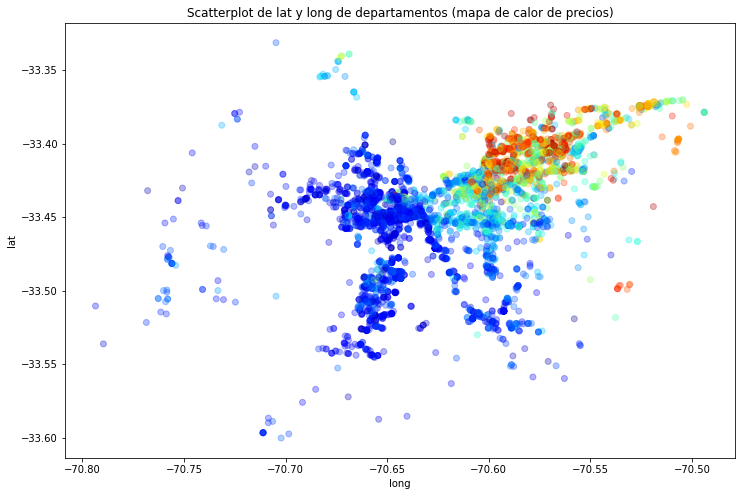

In [116]:
plt.figure(figsize=(12,8)) 
plt.scatter(df['long'], df['lat'],
c = df['precio_total'], cmap=plt.get_cmap("jet"), alpha = 0.3)
plt.ylabel('lat')
plt.xlabel('long')
plt.title("Scatterplot de lat y long de departamentos (mapa de calor de precios)")

Text(0.5, 1.0, 'Mapa de ofertas de arriendo de departamento en Santiago de Chile, Abril 2022')

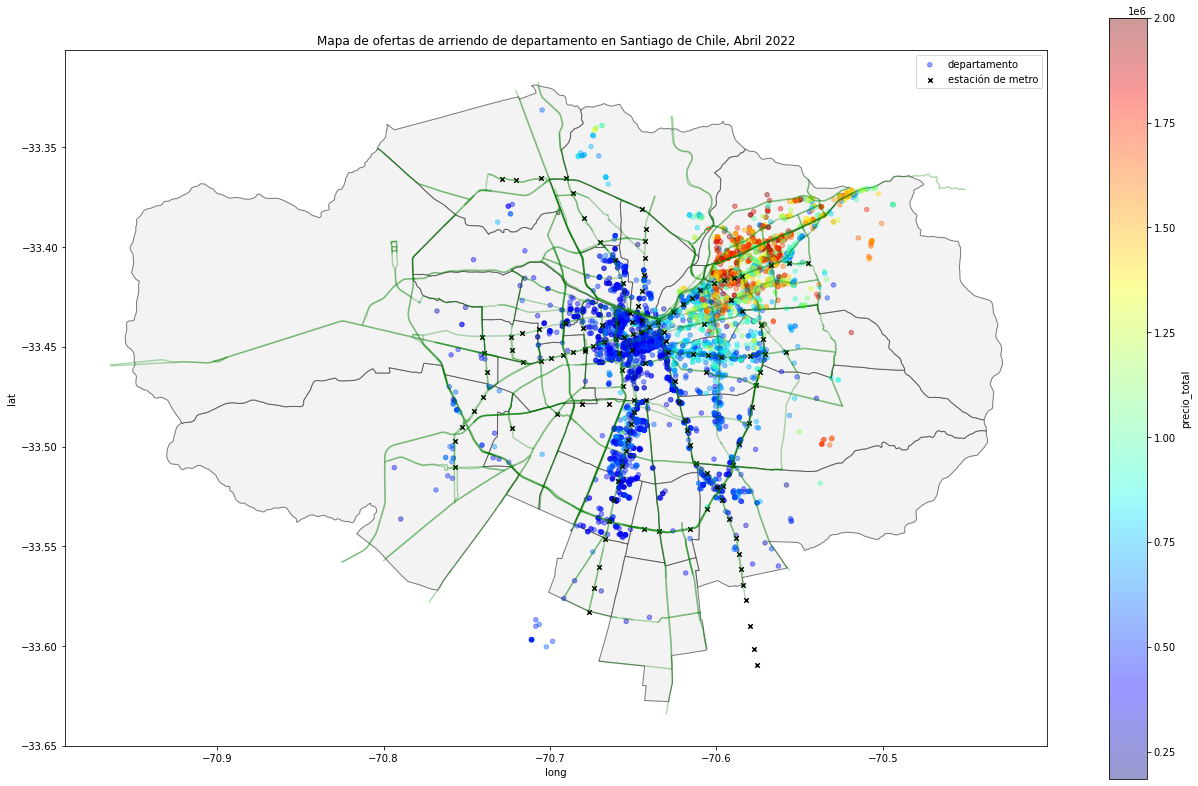

In [117]:
# Santiago
sf_path = "data/shp/comunas/comunas.shp"
sf = gpd.read_file(sf_path, encoding='utf-8')
stgo_sf = sf[(sf.Provincia == 'Santiago') & (sf.Comuna != 'Lo Barnechea')]
stgo_shape = stgo_sf.to_crs({'init': 'epsg:4326'})
# Principales avenidas
roads_path = "data/shp/rutas/gis_osm_roads_free_1.shp"
roads = gpd.read_file(roads_path, encoding='utf-8')
roads = gpd.sjoin(roads, stgo_shape, op='intersects')
main_roads = roads[(roads.fclass == 'primary') | (roads.fclass == 'motorway')]
# Estaciones Metro Santiago
metro = pd.read_csv('../scraping/output/estaciones.csv')
# Plot
ax = stgo_shape.plot(figsize=(22,14), color='#EFEFEF', edgecolor='#444444', alpha = 0.7)
main_roads.plot(ax=ax, color='green', markersize=0.1, alpha = 0.3)
df.plot(x = 'long', y = 'lat', kind = 'scatter', c = 'precio_total', cmap=plt.get_cmap("jet"), label = 'departamento', colorbar = True, ax=ax, alpha = 0.4)
metro.plot(ax=ax, x = 'long', y = 'lat', kind = 'scatter', marker = 'x', color = 'black', label = 'estación de metro')
plt.title("Mapa de ofertas de arriendo de departamento en Santiago de Chile, Abril 2022")

El mapa anterior muestra las divisiones de comunas de Santiago, las lineas verdes representa las principales avenidas de la ciudad, las cruces negras representa las estaciones de metros de Santiago y los circulos representa cada uno de los departamentos ofrecidos, además cada departamento se asocia al mapa de calor del precio total del departamento, que va desde los colores morados los precios más económicos hasta los colores rojos los más caros ofrecidos.

Se puede observar una alta densidad de departamentos en las comuna de Santiago, también se observa como la densidad de la oferta se conglomera alrededor de las princiaples avenidas y cercana a estaciones de metro, principalmente en la zona sur. Además, se observa que los precios más altos de la oferta se conglomeran en el sector oriente de Santiago.